# Extract WRF Data
__Author__: Pat McCornack

__Date__: 11-22-24

__Description__: Extracts WRF data for specified site coordinates for comparison with observational data. Outputs extracted data as pickled dataframe. 

__Site Coordinates__: 
- Sauces:  34° 0'3.72"N, 119°49'4.14"W (LAT: 34.001033, LONG: -119.817817)
- UPEM:  34° 0'45.11"N, 119°48'6.58"W (LAT: 34.012531, LONG: -119.801828)
- NRS SCI: LAT: 33.995943, LONG: -119.716437


In [2]:
import os 
import glob 

import numpy as np
import pandas as pd
import xarray as xr
import netCDF4

import matplotlib.pyplot as plt
from   matplotlib.lines import Line2D

# Functions

In [3]:
def build_np_stack(files, np_stack, caldata, var):
    #### Build np stack of rasters ####
    for m in range(len(files)):
        #print (files[m])
        f2 = xr.open_dataset(files[m])
        f2 = f2[[var, 'Times']]

        # Get start date in file
        tot = len(f2['Times'].values)  # how many hours
        tmp = str(f2['Times'][0].values)  # Get first datetime
        tmp = tmp[2:-1]
        xd1 = tmp.replace('_', ' ')

        # Get end date in file
        tmp = str(f2['Times'][tot-1].values)
        tmp = tmp[2:-1]
        xd2 = tmp.replace('_', ' ')

        # Get indexes from calendar that match start/end dates
        id1 = np.squeeze(np.where(caldata == xd1))
        id2 = np.squeeze(np.where(caldata == xd2)  )

        # Create stack of rasters indexed according to calendar and trimmed by geographic bounds
        f2 = f2[var]
        np_stack[id1:id2+1,:,:] = f2[:,i1:i2+1,j1:j2+1]

    return np_stack

def extract_dataframe(xrstack, terrain, xlat, xlon):
    # Find closest WRF cell to station and extract time series
    slat = xrstack['XLAT'].values
    slon = xrstack['XLONG'].values
    dist = np.sqrt((slat - xlat)**2 + (slon - xlon)**2)
    ind  = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
    np.shape(slat),np.shape(slon),np.shape(dist),ind
    darray = xrstack[:,ind[0],ind[1]]
    darray  = darray.drop('XLAT')
    darray  = darray.drop('XLONG')
    df = darray.to_dataframe()
    elev = terrain[ind[0],ind[1]].values
    return df


def calc_RH(T2, PSFC, Q2):
    T2 = T2 - 273  # Convert from K to C
    PSFC = PSFC / 100  # Convert from Pa to hPa
    es = 6.11 * 10**((7.5*T2)/(T2+237.3))
    qs = 0.622 * es/(PSFC-0.378*es)
    rh2 = 100 * Q2/qs

    return rh2

# Prepare Data 

## Prepare Terrain/Land Mask

In [4]:
#### 
#  Open geogrid file
file     = '/home/sbarc/wrf/wrf401/sbareg/geo_em.d04.nc'
ds       = xr.open_dataset(file)
ds

#   read one 2DVar file to get coordinates
path     = '/home/sbarc/wrf/wrf401/sbareg/'
yr1      = 1988
m        = 0
files    = sorted(glob.glob(path + str(yr1+m) + '/wrfout_d04_2DVar_*.nc'))
f2       = xr.open_dataset(files[m])

#   creat xarray
terrain  = xr.DataArray(ds['HGT_M'][0,:,:].values, dims =("south_north","west_east"), name="terrain",     
                    coords={"XLAT":f2['XLAT'],"XLONG":f2['XLONG']},
                    attrs ={'terrain':'elevation (m)'})
#   creat landmask
landmask = xr.DataArray(ds['LANDMASK'][0,:,:].values, dims =("south_north","west_east"), name="landmask",     
                    coords={"XLAT":f2['XLAT'],"XLONG":f2['XLONG']},
                    attrs ={'landmask':'landmask (m)'})

In [5]:
f2

<xarray.Dataset>
Dimensions:   (Time: 24, bottom_top: 54, south_north: 234, west_east: 258)
Coordinates:
    XLAT      (south_north, west_east) float32 ...
    XLONG     (south_north, west_east) float32 ...
Dimensions without coordinates: Time, bottom_top, south_north, west_east
Data variables:
    HGT       (south_north, west_east) float32 ...
    Times     (Time) |S19 ...
    Q2        (Time, south_north, west_east) float32 ...
    T2        (Time, south_north, west_east) float32 ...
    TH2       (Time, south_north, west_east) float32 ...
    PSFC      (Time, south_north, west_east) float32 ...
    U10       (Time, south_north, west_east) float32 ...
    V10       (Time, south_north, west_east) float32 ...
    FGDP      (Time, south_north, west_east) float32 ...
    DFGDP     (Time, south_north, west_east) float32 ...
    VDFG      (Time, south_north, west_east) float32 ...
    RAINNC    (Time, south_north, west_east) float32 ...
    I_RAINNC  (Time, south_north, west_east) int32 ...
    CLDFRA    (Time, bottom_top, south_north, west_east) float32 ...
    LWUPB     (Time, south_north, west_east) float32 ...
    LWDNB     (Time, south_north, west_east) float32 ...
    SWUPB     (Time, south_north, west_east) float32 ...
    SWDNB     (Time, south_north, west_east) float32 ...
    UST       (Time, south_north, west_east) float32 ...
    HFX       (Time, south_north, west_east) float32 ...
    QFX       (Time, south_north, west_east) float32 ...
    LH        (Time, south_north, west_east) float32 ...
    GRDFLX    (Time, south_north, west_east) float32 ...
    PBLH      (Time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V4.0.1 MODEL
    START_DATE:                      1987-07-01_00:00:00
    SIMULATION_START_DATE:           1987-07-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        259
    SOUTH-NORTH_GRID_DIMENSION:      235
    BOTTOM-TOP_GRID_DIMENSION:       55
    DX:                              1000.0
    DY:                              1000.0
    AERCU_OPT:                       0
    AERCU_FCT:                       1.0
    IDEAL_CASE:                      0
    DIFF_6TH_SLOPEOPT:               0
    AUTO_LEVELS_OPT:                 2
    DIFF_6TH_THRESH:                 0.1
    DZBOT:                           50.0
    DZSTRETCH_S:                     1.3
    DZSTRETCH_U:                     1.1
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    GRIDTYPE:                        C
    DIFF_OPT:                        2
    KM_OPT:                          4
    DAMP_OPT:                        3
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      6
    RA_LW_PHYSICS:                   4
    RA_SW_PHYSICS:                   4
    SF_SFCLAY_PHYSICS:               5
    SF_SURFACE_PHYSICS:              4
    BL_PBL_PHYSICS:                  5
    CU_PHYSICS:                      0
    SF_LAKE_PHYSICS:                 0
    SURFACE_INPUT_SOURCE:            1
    SST_UPDATE:                      1
    GRID_FDDA:                       0
    GFDDA_INTERVAL_M:                0
    GFDDA_END_H:                     0
    GRID_SFDDA:                      0
    SGFDDA_INTERVAL_M:               0
    SGFDDA_END_H:                    0
    HYPSOMETRIC_OPT:                 2
    USE_THETA_M:                     1
    GWD_OPT:                         0
    SF_URBAN_PHYSICS:                0
    SF_SURFACE_MOSAIC:               0
    SF_OCEAN_PHYSICS:                0
    SHCU_PHYSICS:                    0
    MFSHCONV:                        0
    FEEDBACK:                        1
    SMOOTH_OPTION:                   0
    SWRAD_SCAT:                      1.0
    W_DAMPING:                       0
    DT:                              3.3333333
    RADT:                            10.0
    BLDT:      

## Select Domain to Crop

In [6]:
#### Define geographic domain ####
i1 = 20
i2 = 135
j1 = 50
j2 = 199

In [7]:
#### Crop terrain and landmask ####
terrain  = terrain[i1:i2+1,j1:j2+1]
landmask = landmask[i1:i2+1,j1:j2+1]
landmask.shape

(116, 150)

## Create list of dates

In [8]:
#### Create calendar data for years to extract ####
yr1      = 2003
yr2      = 2010
nyrs     = yr2 - yr1  + 1
dstart   = str(yr1-1) + '-07-01'
dend     = str(yr2)   + "-12-31"
caldata  = pd.date_range(start=dstart,end=dend,freq="H")

# Extract data

In [9]:
#### Define where to save data ####
outdir = '~/data/wrf_extracted'

In [10]:
#### Get list of files ####
data_dir     = '/home/sbarc/wrf/wrf401/sbareg/'
years = list(range(yr1, yr2+1))
years = [str(year) for year in years]

files = []
for year in years:
    files.append(sorted(glob.glob(path + year + '/wrfout_d04_2DVar_*.nc')))
    
# Flatten list
files = [file for sublist in files for file in sublist]

## Extract Fog Data

In [12]:
#### Create stack of numpy rasters ####
mlat  = i2 - i1 + 1
mlon  = j2 - j1 + 1
mtot  = len(caldata)
np_stack  = np.zeros((mtot,mlat,mlon))
run = 0

np_stack = build_np_stack(files, np_stack, caldata, var='DFGDP')

#### Cast numpy array stack to xarray dataset ####
darray = xr.DataArray(np_stack, dims =("times","south_north","west_east"), name="DFGDP",     
                 coords={"times":caldata,"XLAT":terrain['XLAT'],"XLONG":terrain['XLONG']},
                 attrs ={'DFGDP':'fog deposition during timestep (mm)'})

if run == 1:
    #### SAUC DataFrame ####
    xlat =   34.001033
    xlon = -119.817817
    sauc_df  = extract_dataframe(darray, terrain, xlat, xlon)

    # Save out dataframe as pickle
    out_fname = 'wrf_sauc_DFGDP_2003-2010.pkl'
    sauc_df.to_pickle(os.path.join(outdir, out_fname))

    #### UPEM DataFrame ####
    xlat =   34.012531
    xlon = -119.801828
    upem_df = extract_dataframe(darray, terrain, xlat, xlon)

    # Save out dataframe as pickle
    out_fname = 'wrf_upem_DFGDP_2003-2010.pkl'
    upem_df.to_pickle(os.path.join(outdir, out_fname))

#### NRS SCI Dataframe ####
xlat =   33.995943
xlon = -119.716437
nrs_sci_df = extract_dataframe(darray, terrain, xlat, xlon)

# Save out dataframe as pickle
out_fname = 'wrf_nrs_sci_DFGDP_2003-2010.pkl'
nrs_sci_df.to_pickle(os.path.join(outdir, out_fname))

## Extract Air Temperature

In [13]:
#### Create stack of numpy rasters ####
mlat  = i2 - i1 + 1
mlon  = j2 - j1 + 1
mtot  = len(caldata)
np_stack  = np.zeros((mtot,mlat,mlon))

np_stack = build_np_stack(files, np_stack, caldata, var='T2')

#### Cast numpy array stack to xarray dataset ####
darray = xr.DataArray(np_stack, dims =("times","south_north","west_east"), name="T2",     
                 coords={"times":caldata,"XLAT":terrain['XLAT'],"XLONG":terrain['XLONG']},
                 attrs ={'T2':'air temperature at 2m (K)'})

if run == 1:
    #### SAUC DataFrame ####
    xlat =   34.001033
    xlon = -119.817817
    sauc_df  = extract_dataframe(darray, terrain, xlat, xlon)
    # Save out dataframe as pickle
    out_fname = 'wrf_sauc_T2_2003-2010.pkl'
    sauc_df.to_pickle(os.path.join(outdir, out_fname))

    #### UPEM DataFrame ####
    xlat =   34.012531
    xlon = -119.801828
    upem_df = extract_dataframe(darray, terrain, xlat, xlon)
    # Save out dataframe as pickle
    out_fname = 'wrf_upem_T2_2003-2010.pkl'
    upem_df.to_pickle(os.path.join(outdir, out_fname))

#### NRS SCI Dataframe ####
xlat =   33.995943
xlon = -119.716437
nrs_sci_df = extract_dataframe(darray, terrain, xlat, xlon)

# Save out dataframe as pickle
out_fname = 'wrf_nrs_sci_T2_2003-2010.pkl'
nrs_sci_df.to_pickle(os.path.join(outdir, out_fname))

## Extract Specific Humidity

In [14]:
#### Create stack of numpy rasters ####
mlat  = i2 - i1 + 1
mlon  = j2 - j1 + 1
mtot  = len(caldata)
np_stack  = np.zeros((mtot,mlat,mlon))

np_stack = build_np_stack(files, np_stack, caldata, var='Q2')

#### Cast numpy array stack to xarray dataset ####
darray = xr.DataArray(np_stack, dims =("times","south_north","west_east"), name="Q2",     
                 coords={"times":caldata,"XLAT":terrain['XLAT'],"XLONG":terrain['XLONG']},
                 attrs ={'Q2':'specific humidity at 2m (kg kg-1)'})

if run == 1:
    #### SAUC DataFrame ####
    xlat =   34.001033
    xlon = -119.817817
    sauc_df  = extract_dataframe(darray, terrain, xlat, xlon)
    # Save out dataframe as pickle
    out_fname = 'wrf_sauc_Q2_2003-2010.pkl'
    sauc_df.to_pickle(os.path.join(outdir, out_fname))


    #### UPEM DataFrame ####
    xlat =   34.012531
    xlon = -119.801828
    upem_df = extract_dataframe(darray, terrain, xlat, xlon)
    # Save out dataframe as pickle
    out_fname = 'wrf_upem_Q2_2003-2010.pkl'
    upem_df.to_pickle(os.path.join(outdir, out_fname))
    
#### NRS SCI Dataframe ####
xlat =   33.995943
xlon = -119.716437
nrs_sci_df = extract_dataframe(darray, terrain, xlat, xlon)

# Save out dataframe as pickle
out_fname = 'wrf_nrs_sci_Q2_2003-2010.pkl'
nrs_sci_df.to_pickle(os.path.join(outdir, out_fname))



## Extract Surface Pressure 

In [15]:
#### Create stack of numpy rasters ####
mlat  = i2 - i1 + 1
mlon  = j2 - j1 + 1
mtot  = len(caldata)
np_stack  = np.zeros((mtot,mlat,mlon))

np_stack = build_np_stack(files, np_stack, caldata, var='PSFC')

#### Cast numpy array stack to xarray dataset ####
darray = xr.DataArray(np_stack, dims =("times","south_north","west_east"), name="PSFC",     
                 coords={"times":caldata,"XLAT":terrain['XLAT'],"XLONG":terrain['XLONG']},
                 attrs ={'PSFC':'surface pressure (Pa)'})

if run == 1:
    #### SAUC DataFrame ####
    xlat =   34.001033
    xlon = -119.817817
    sauc_df  = extract_dataframe(darray, terrain, xlat, xlon)
    # Save out dataframe as pickle
    out_fname = 'wrf_sauc_PSFC_2003-2010.pkl'
    sauc_df.to_pickle(os.path.join(outdir, out_fname))

    #### UPEM DataFrame ####
    xlat =   34.012531
    xlon = -119.801828
    upem_df = extract_dataframe(darray, terrain, xlat, xlon)
    # Save out dataframe as pickle
    out_fname = 'wrf_upem_PSFC_2003-2010.pkl'
    upem_df.to_pickle(os.path.join(outdir, out_fname))

#### NRS SCI Dataframe ####
xlat =   33.995943
xlon = -119.716437
nrs_sci_df = extract_dataframe(darray, terrain, xlat, xlon)

# Save out dataframe as pickle
out_fname = 'wrf_nrs_sci_PSFC_2003-2010.pkl'
nrs_sci_df.to_pickle(os.path.join(outdir, out_fname))

## Extract Longwave Upwelling

In [16]:
#### Create stack of numpy rasters ####
mlat  = i2 - i1 + 1
mlon  = j2 - j1 + 1
mtot  = len(caldata)
np_stack  = np.zeros((mtot,mlat,mlon))

np_stack = build_np_stack(files, np_stack, caldata, var='LWUPB')

#### Cast numpy array stack to xarray dataset ####
darray = xr.DataArray(np_stack, dims =("times","south_north","west_east"), name="LWUPB",     
                 coords={"times":caldata,"XLAT":terrain['XLAT'],"XLONG":terrain['XLONG']},
                 attrs ={'LWUPB':'instantaneous longwave upwelling radiation (W m-2)'})

if run == 1:
    #### SAUC DataFrame ####
    xlat =   34.001033
    xlon = -119.817817
    sauc_df  = extract_dataframe(darray, terrain, xlat, xlon)
    # Save out dataframe as pickle
    out_fname = 'wrf_sauc_LWUPB_2003-2010.pkl'
    sauc_df.to_pickle(os.path.join(outdir, out_fname))

    #### UPEM DataFrame ####
    xlat =   34.012531
    xlon = -119.801828
    LWUPB_df = extract_dataframe(darray, terrain, xlat, xlon)
    # Save out dataframe as pickle
    out_fname = 'wrf_upem_LWUPB_2003-2010.pkl'
    sauc_df.to_pickle(os.path.join(outdir, out_fname))
    
#### NRS SCI Dataframe ####
xlat =   33.995943
xlon = -119.716437
nrs_sci_df = extract_dataframe(darray, terrain, xlat, xlon)

# Save out dataframe as pickle
out_fname = 'wrf_nrs_sci_LWUPB_2003-2010.pkl'
nrs_sci_df.to_pickle(os.path.join(outdir, out_fname))



## Extract Longwave Downwelling

In [ ]:
#### Create stack of numpy rasters ####
mlat  = i2 - i1 + 1
mlon  = j2 - j1 + 1
mtot  = len(caldata)
np_stack  = np.zeros((mtot,mlat,mlon))

np_stack = build_np_stack(files, np_stack, caldata, var='LWDNB')

#### Cast numpy array stack to xarray dataset ####
darray = xr.DataArray(np_stack, dims =("times","south_north","west_east"), name="LWDNB",     
                 coords={"times":caldata,"XLAT":terrain['XLAT'],"XLONG":terrain['XLONG']},
                 attrs ={'LWDNB':'instantaneous longwave downwelling radiation (W m-2)'})

if run == 1:
    #### SAUC DataFrame ####
    xlat =   34.001033
    xlon = -119.817817
    sauc_df  = extract_dataframe(darray, terrain, xlat, xlon)
    # Save out dataframe as pickle
    out_fname = 'wrf_sauc_LWDNB_2003-2010.pkl'
    sauc_df.to_pickle(os.path.join(outdir, out_fname))

    #### UPEM DataFrame ####
    xlat =   34.012531
    xlon = -119.801828
    LWDNB_df = extract_dataframe(darray, terrain, xlat, xlon)
    # Save out dataframe as pickle
    out_fname = 'wrf_upem_LWDNB_2003-2010.pkl'
    sauc_df.to_pickle(os.path.join(outdir, out_fname))

#### NRS SCI Dataframe ####
xlat =   33.995943
xlon = -119.716437
nrs_sci_df = extract_dataframe(darray, terrain, xlat, xlon)

# Save out dataframe as pickle
out_fname = 'wrf_nrs_sci_LWDNB_2003-2010.pkl'
nrs_sci_df.to_pickle(os.path.join(outdir, out_fname))

## Extract Shortwave Upwelling

In [18]:
#### Create stack of numpy rasters ####
mlat  = i2 - i1 + 1
mlon  = j2 - j1 + 1
mtot  = len(caldata)
np_stack  = np.zeros((mtot,mlat,mlon))

np_stack = build_np_stack(files, np_stack, caldata, var='SWUPB')

#### Cast numpy array stack to xarray dataset ####
darray = xr.DataArray(np_stack, dims =("times","south_north","west_east"), name="SWUPB",     
                 coords={"times":caldata,"XLAT":terrain['XLAT'],"XLONG":terrain['XLONG']},
                 attrs ={'SWUPB':'instantaneous shortwave upwelling radiation (W m-2)'})
if run == 1:
    #### SAUC DataFrame ####
    xlat =   34.001033
    xlon = -119.817817
    sauc_df  = extract_dataframe(darray, terrain, xlat, xlon)
    # Save out dataframe as pickle
    out_fname = 'wrf_sauc_SWUPB_2003-2010.pkl'
    sauc_df.to_pickle(os.path.join(outdir, out_fname))

    #### UPEM DataFrame ####
    xlat =   34.012531
    xlon = -119.801828
    SWUPB_df = extract_dataframe(darray, terrain, xlat, xlon)
    # Save out dataframe as pickle
    out_fname = 'wrf_upem_SWUPB_2003-2010.pkl'
    sauc_df.to_pickle(os.path.join(outdir, out_fname))
    
#### NRS SCI Dataframe ####
xlat =   33.995943
xlon = -119.716437
nrs_sci_df = extract_dataframe(darray, terrain, xlat, xlon)

# Save out dataframe as pickle
out_fname = 'wrf_nrs_sci_SWUPB_2003-2010.pkl'
nrs_sci_df.to_pickle(os.path.join(outdir, out_fname))



## Extract Shortwave Downwelling 

In [19]:
#### Create stack of numpy rasters ####
mlat  = i2 - i1 + 1
mlon  = j2 - j1 + 1
mtot  = len(caldata)
np_stack  = np.zeros((mtot,mlat,mlon))

np_stack = build_np_stack(files, np_stack, caldata, var='SWDNB')

#### Cast numpy array stack to xarray dataset ####
darray = xr.DataArray(np_stack, dims =("times","south_north","west_east"), name="SWDNB",     
                 coords={"times":caldata,"XLAT":terrain['XLAT'],"XLONG":terrain['XLONG']},
                 attrs ={'SWDNB':'instantaneous shortwave downwelling radiation (W m-2)'})
if run == 1:
    #### SAUC DataFrame ####
    xlat =   34.001033
    xlon = -119.817817
    sauc_df  = extract_dataframe(darray, terrain, xlat, xlon)
    # Save out dataframe as pickle
    out_fname = 'wrf_sauc_SWDNB_2003-2010.pkl'
    sauc_df.to_pickle(os.path.join(outdir, out_fname))

    #### UPEM DataFrame ####
    xlat =   34.012531
    xlon = -119.801828
    SWDNB_df = extract_dataframe(darray, terrain, xlat, xlon)
    # Save out dataframe as pickle
    out_fname = 'wrf_upem_SWDNB_2003-2010.pkl'
    sauc_df.to_pickle(os.path.join(outdir, out_fname))

#### NRS SCI Dataframe ####
xlat =   33.995943
xlon = -119.716437
nrs_sci_df = extract_dataframe(darray, terrain, xlat, xlon)

# Save out dataframe as pickle
out_fname = 'wrf_nrs_sci_SWDNB_2003-2010.pkl'
nrs_sci_df.to_pickle(os.path.join(outdir, out_fname))

# Aggregate pkl files to single file

In [24]:
var_list = ['T2', 'Q2', 'PSFC', 'LWUPB', 'LWDNB', 'SWUPB', 'SWDNB']
data_dir = '~/data/wrf_extracted'


#### SAUC ####
var = 'DFGDP'
fname = f'wrf_sauc_{var}_2003-2010.pkl'
sauc_df = pd.read_pickle(os.path.join(data_dir, fname))

for var in var_list:
    fname = f'wrf_sauc_{var}_2003-2010.pkl'
    df = pd.read_pickle(os.path.join(data_dir, fname))
    sauc_df = pd.concat([sauc_df, df], axis=1)
    
sauc_outfname = 'wrf_sauc_2003-2010.pkl'
sauc_df.to_pickle(os.path.join(data_dir, sauc_outfname))
    
                  
#### UPEM ####
var = 'DFGDP'
fname = f'wrf_upem_{var}_2003-2010.pkl'
upem_df = pd.read_pickle(os.path.join(data_dir, fname))

for var in var_list:
    fname = f'wrf_upem_{var}_2003-2010.pkl'
    df = pd.read_pickle(os.path.join(data_dir, fname))
    upem_df = pd.concat([upem_df, df], axis=1)
                  
upem_outfname = 'wrf_upem_2003-2010.pkl'
upem_df.to_pickle(os.path.join(data_dir, upem_outfname))

#### NRS SCI ####
var = 'DFGDP'
fname = f'wrf_nrs_sci_{var}_2003-2010.pkl'
nrs_sci_df = pd.read_pickle(os.path.join(data_dir, fname))

for var in var_list:
    fname = f'wrf_nrs_sci_{var}_2003-2010.pkl'
    df = pd.read_pickle(os.path.join(data_dir, fname))
    nrs_sci_df = pd.concat([nrs_sci_df, df], axis=1)
                  
nrs_sci_outfname = 'wrf_nrs_sci_2003-2010.pkl'
nrs_sci_df.to_pickle(os.path.join(data_dir, nrs_sci_outfname))

# Create RH variable

In [61]:
#### SAUC #####
data_dir = '~/data/wrf_extracted'
sauc_fname = 'wrf_sauc_2003-2010.pkl'
sauc_df = pd.read_pickle(os.path.join(data_dir, sauc_fname))

RH = calc_RH(sauc_df['T2'], sauc_df['PSFC'], sauc_df['Q2'])
RH.loc[RH > 100] = 100  # Cap RH at 100
sauc_df['RH'] = RH


In [44]:
#### UPEM ####
data_dir = '~/data/wrf_extracted'
upem_fname = 'wrf_upem_2003-2010.pkl'
upem_df = pd.read_pickle(os.path.join(data_dir, upem_fname))

RH = calc_RH(upem_df['T2'], upem_df['PSFC'], upem_df['Q2'])
RH.loc[RH > 100] = 100  # Cap RH at 100
upem_df['RH'] = RH

In [23]:
#### NRS SCI ####
data_dir = '~/data/wrf_extracted'
nrs_sci_fname = 'wrf_nrs_sci_2003-2010.pkl'
nrs_sci_df = pd.read_pickle(os.path.join(data_dir, nrs_sci_fname))

RH = calc_RH(nrs_sci_df['T2'], nrs_sci_df['PSFC'], nrs_sci_df['Q2'])
RH.loc[RH > 100] = 100  # Cap RH at 100
nrs_sci_df['RH'] = RH

## Trim tail of dataset
Every variable seems to drop to zero at a certain point, cut this off. 

<AxesSubplot:xlabel='times'>

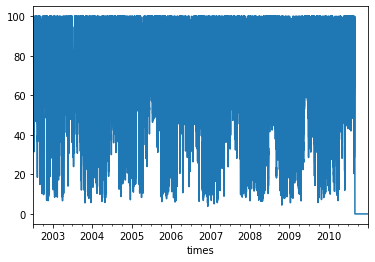

In [62]:
sauc_df['RH'].plot()

In [58]:
upem_df = upem_df[:'2010-08-31 23:00:00']  # Cuts off end of August
upem_df.describe()

,fogdep,T2,Q2,PSFC,LWUPB,LWDNB,SWUPB,SWDNB,RH
count,71616.000000,71616.000000,71616.000000,71616.000000,71616.000000,71616.000000,71616.000000,71616.000000,71616.000000
mean,0.000002,289.034287,0.006435,97648.879436,402.986219,305.604445,40.461768,248.698238,57.957708
std,0.000010,5.591913,0.002478,383.907577,51.619194,31.494111,53.232681,329.414390,26.351834
min,0.000000,273.180420,0.000600,94786.828125,0.000000,0.000000,0.000000,0.000000,3.722852
25%,0.000000,284.696228,0.004682,97390.531250,364.778084,282.707458,0.000000,0.000000,35.899248
50%,0.000000,288.358078,0.006607,97600.242188,386.882050,302.784958,0.000000,0.000000,59.566632
75%,0.000000,292.799355,0.008245,97891.484375,432.630539,326.160179,82.878563,504.801292,79.529600
max,0.000278,311.547577,0.015175,99150.546875,644.770020,455.957397,182.498260,1105.630981,100.000000


In [63]:
sauc_df = sauc_df[:'2010-08-31 23:00:00']  # Cuts off end of August
sauc_df.describe()

,fogdep,T2,Q2,PSFC,LWUPB,LWDNB,SWUPB,SWDNB,RH
count,71616.000000,71616.000000,71616.000000,71616.000000,71616.000000,71616.000000,71616.000000,71616.000000,71616.000000
mean,0.000002,288.010938,0.006939,98364.958501,402.986219,305.604445,40.461768,248.698238,66.370055
std,0.000010,4.928535,0.002387,388.740432,51.619194,31.494111,53.232681,329.414390,25.783607
min,0.000000,273.959900,0.000597,95507.023438,0.000000,0.000000,0.000000,0.000000,3.784658
25%,0.000000,284.402596,0.005460,98101.453125,364.778084,282.707458,0.000000,0.000000,49.544318
50%,0.000000,287.206726,0.007256,98315.261719,386.882050,302.784958,0.000000,0.000000,70.480676
75%,0.000000,291.019363,0.008674,98613.828125,432.630539,326.160179,82.878563,504.801292,88.031097
max,0.000278,310.120789,0.015168,99872.640625,644.770020,455.957397,182.498260,1105.630981,100.000000


In [27]:
nrs_sci_df = nrs_sci_df[:'2010-08-31 23:00:00']  # Cuts off end of August
nrs_sci_df.describe()

,DFGDP,T2,Q2,PSFC,LWUPB,LWDNB,SWUPB,SWDNB,RH
count,7.161600e+04,71616.000000,71616.000000,71616.000000,71616.000000,71616.000000,71616.000000,71616.000000,71616.000000
mean,1.408859e-07,289.947718,0.006720,99618.527638,408.383891,311.667481,42.395429,246.324991,57.860683
std,2.726858e-06,5.602405,0.002608,405.315867,49.818882,32.269701,55.631394,324.574283,25.770081
min,0.000000e+00,273.661438,0.000724,96757.140625,0.000000,0.000000,0.000000,0.000000,4.092034
25%,0.000000e+00,285.699615,0.004720,99340.351562,370.022850,288.213295,0.000000,0.000000,36.515666
50%,0.000000e+00,289.169067,0.006858,99568.437500,395.959488,309.510971,0.018001,0.085966,58.902015
75%,0.000000e+00,293.506264,0.008744,99879.271484,440.027077,333.903877,85.110971,500.681999,78.912478
max,1.667414e-04,315.857239,0.015293,101184.140625,640.116211,445.689026,198.469238,1097.662720,100.000000


In [73]:
#### Save out clean SAUC ####
data_dir = '~/data/wrf_extracted'
sauc_fname = 'wrf_sauc_2003-2010.pkl'
sauc_df.to_pickle(os.path.join(data_dir, sauc_fname))

In [78]:
#### Save out clean UPEM ####
data_dir = '~/data/wrf_extracted'
upem_fname = 'wrf_upem_2003-2010.pkl'
upem_df.to_pickle(os.path.join(data_dir, upem_fname))

/home/patmccornack/.local/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
#### Save out clean NRS SCI ####
data_dir = '~/data/wrf_extracted'
nrs_sci_fname = 'wrf_nrs_sci_2003-2010.pkl'
nrs_sci_df.to_pickle(os.path.join(data_dir, nrs_sci_fname))